In [15]:
# Importing packages needed

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import yfinance as yf

In [16]:
# Set the ticker symbol and date range
ticker = input("Enter the ticker symbol (e.g., AAPL, BTC-USD): ").strip().upper()
start_date = "2016-01-01"
end_date = "2024-12-3"

# Uncomment for user date input
# start_date = input("Enter the start date (YYYY-MM-DD): ").strip()
# end_date = input("Enter the end date (YYYY-MM-DD): ").strip()

# Download the data using yfinance
data = yf.download(ticker, start=start_date, end=end_date)

# Flatten the MultiIndex columns if necessary
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Keep only the 'Close' column
data = data[['Close']]

# Reset the index to make 'Date' a regular column (removes 'Date' from index)
data.reset_index(inplace=True)

# Check the first few rows to ensure it looks good
print(data.head())


Enter the ticker symbol (e.g., AAPL, BTC-USD):  BA


[*********************100%***********************]  1 of 1 completed

        Date       Close
0 2016-01-04  126.005089
1 2016-01-05  126.516312
2 2016-01-06  124.507385
3 2016-01-07  119.287811
4 2016-01-08  116.579384


In [17]:
# Connect to (or create) an SQLite database file
conn = sqlite3.connect('prices.db')

# Save the data to a table called 'prices'
data.to_sql('prices', conn, if_exists='replace', index=False)

# Commit the transaction and close the connection
conn.commit()
conn.close()

print("Data saved to SQLite database successfully!")


Data saved to SQLite database successfully!


In [18]:
# Reconnect to the SQLite database
conn = sqlite3.connect('prices.db')

# SQL query to get the first and last closing price per month based on the first and last date of each month
query = """
WITH First_Last AS (
    SELECT 
        strftime('%Y-%m', Date) AS Month,
        MIN(Date) AS First_Date,
        MAX(Date) AS Last_Date
    FROM prices
    GROUP BY Month
)
SELECT 
    fl.Month,
    p_first.Close AS First_Close,
    p_last.Close AS Last_Close
FROM First_Last fl
JOIN prices p_first ON p_first.Date = fl.First_Date
JOIN prices p_last ON p_last.Date = fl.Last_Date
"""

# Execute the query and load the result into a DataFrame
monthly_data = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Calculate the monthly returns
monthly_data['Monthly_Return'] = ((monthly_data['Last_Close'] - monthly_data['First_Close']) / monthly_data['First_Close']) * 100

# Check the first few rows of the result
print(monthly_data.head())


     Month  First_Close  Last_Close  Monthly_Return
0  2016-01   126.005089  107.736610      -14.498207
1  2016-02   109.019081  106.968575       -1.880869
2  2016-03   108.579697  114.897522        5.818607
3  2016-04   114.915627  122.011864        6.175172
4  2016-05   121.296814  115.113853       -5.097381


In [19]:
# Calculate daily returns
data['Daily_Return'] = data['Close'].pct_change()

# Calculate the standard deviation (volatility) of daily returns
daily_volatility = data['Daily_Return'].std()

# Annualize the volatility (multiply by sqrt(n) to scale to a yearly basis)
num_trading_days = 252 # 252 is correct for equities, however for something like Bitcoin which trades 24/7, 365 would be more accurate 
annualized_volatility = daily_volatility * (num_trading_days**0.5)

print(f"Daily Volatility: {daily_volatility}")
print(f"Annualized Volatility: {annualized_volatility}")


Daily Volatility: 0.026425992937841158
Annualized Volatility: 0.41949963276886115


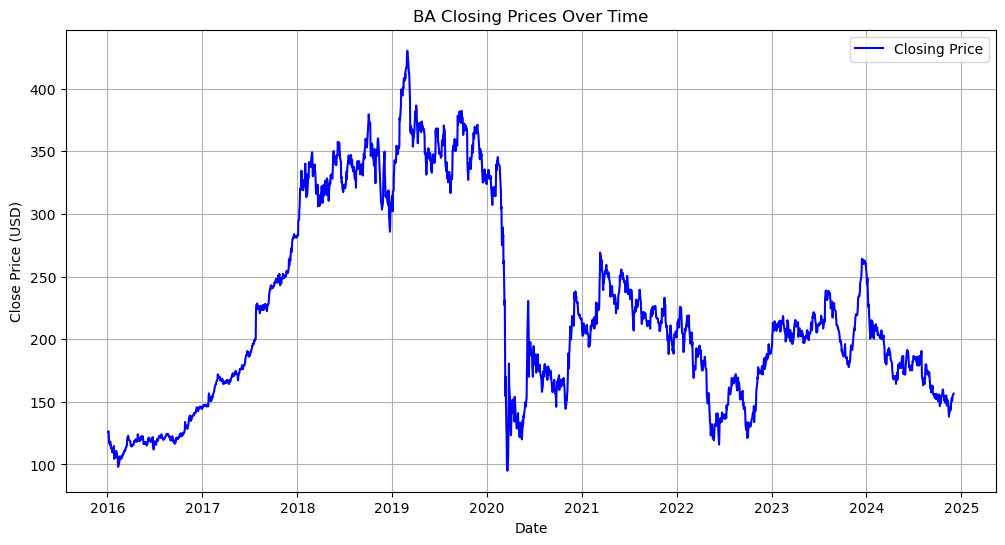

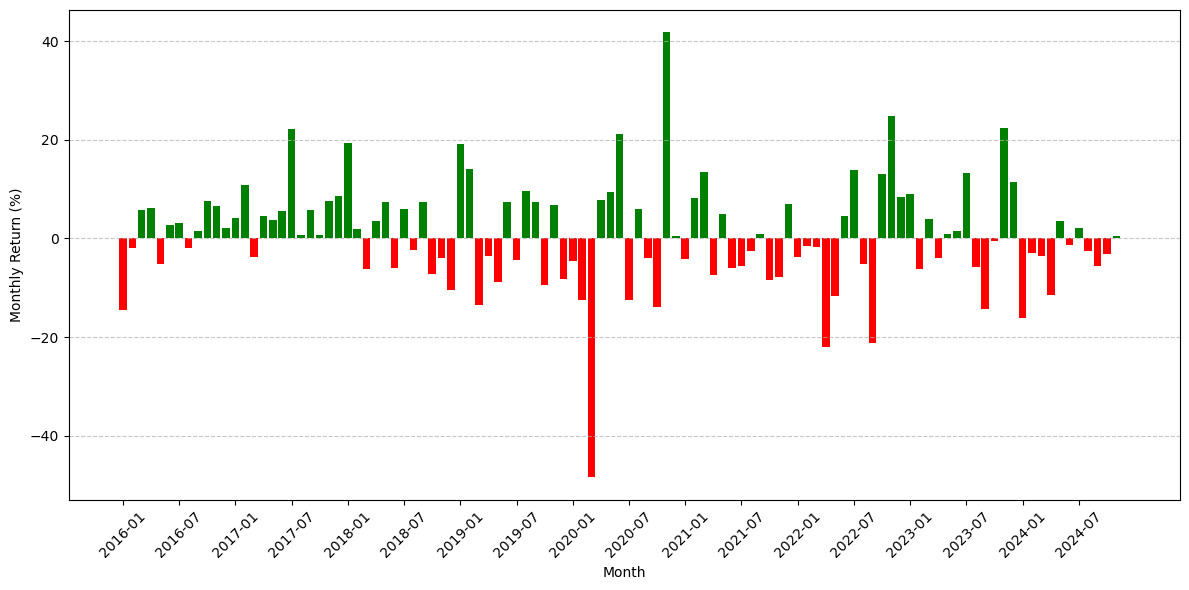

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label="Closing Price", color='blue')
plt.title(f'{ticker} Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))  # Increase the figure size to give more space

# Set colors based on the monthly return
colors = ['green' if x > 0 else 'red' for x in monthly_data['Monthly_Return']]

plt.bar(monthly_data['Month'], monthly_data['Monthly_Return'], color=colors)

plt.xlabel('Month')
plt.ylabel('Monthly Return (%)')

# Adjusts label crowding issues for long datasets
if len(monthly_data) > 50:
    plt.xticks(ticks=range(0, len(monthly_data), 6), labels=monthly_data['Month'][::6], rotation=45)

# Add gridlines to make the plot easier to read
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Increase spacing for labels and add a little padding
plt.tight_layout()

plt.show()
